## Sampling Implementation of QGRNN in Pennylane - 2 Qubits

In [1]:
import numpy
import math
import random
import numpy as np
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
import networkx as nx
import pennylane as qml

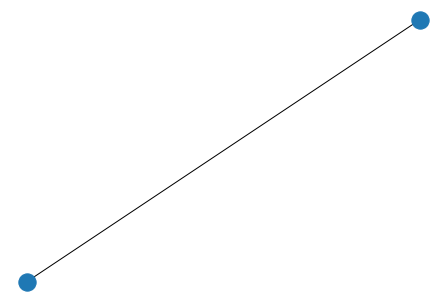

[[-1.87], [-1.77, 1.7]]


[-0.24312594, 1.9419355, 2.81279801]

In [2]:
# Initialize the device on which the simulation is run

qubit_number = 2
qubits = range(0, 2)
vqe_dev = qml.device("default.qubit", wires=qubit_number)

# Creates the graph structure of the quantum system

ising_graph = nx.Graph()
ising_graph.add_nodes_from(range(0, qubit_number))
ising_graph.add_edges_from([(0, 1)])

nx.draw(ising_graph)
plt.show() 

# Creates parameters

matrix_params = [[random.randint(-200, 200)/100], [random.randint(-200, 200)/100, random.randint(-200, 200)/100]]
print(matrix_params)

[-0.24312594,  1.9419355 ,  2.81279801]

In [3]:
# Defines the RZZ gate, in terms of gates in the standard basis set

def RZZ(param, qubit1, qubit2):
    
    qml.CNOT(wires=[qubit1, qubit2])
    qml.RZ(param, wires=qubit2)
    qml.CNOT(wires=[qubit1, qubit2])

# Defines a method that creates an even superposition of basis states

def even_superposition(qubits):
    
    for i in qubits:
        qml.Hadamard(wires=int(i.val))

# Method that prepares the QAOA/time-evolution layer (to be used later)

def qaoa_layer(param1, param2, qubits, ising_graph):
    
    # Applies a layer of coupling gates (based on the graph)
    for count, i in enumerate(ising_graph):
        RZZ(param1[count], int(i[0]), int(i[1]))
    
    # Applies a layer of RX gates
    for count, i in enumerate(qubits):
        qml.RX(param2[count], wires=int(i.val))

# Method that prepares a l0w-energy state        
        
def decoupled_layer(param1, param2, qubits):
    
    # Applies a layer of RZ and RX gates
    for count, i in enumerate(qubits):
        qml.RZ(param1[count], wires=int(i.val))
        qml.RX(param2[count], wires=int(i.val))

# Method that creates the decoupled VQE ansatz

def vqe_circuit(parameters, qubits, depth):
    even_superposition(qubits)
    for i in range(0, int(depth.val)):
        decoupled_layer(parameters[0], parameters[1], qubits)

In [4]:
# Creates the Hamiltonian that we are attempting to learn

def create_hamiltonian_matrix(n, graph):
    
    # Defines Pauli matrices

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))
    
    # Creates the interaction component of the Hamiltonian

    for count, i in enumerate(graph):
        m = 1
        for j in range(0, n):
            if (i[0] == j or i[1] == j):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[0][count]*m)
    
    # Creates the "bias" component of the matrix
    
    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[1][i]*m)

    return matrix

def create_hamiltonian_matrix_param(n, graph, params):
    
    # Defines Pauli matrices

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))
    
    # Creates the interaction component of the Hamiltonian

    for count, i in enumerate(graph):
        m = 1
        for j in range(0, n):
            if (i[0] == j or i[1] == j):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, params[0][count]*m)
    
    # Creates the "bias" component of the matrix
    
    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, params[1][i]*m)

    return matrix

print(create_hamiltonian_matrix(qubit_number, ising_graph.edges))

[[-1.87  1.7  -1.77  0.  ]
 [ 1.7   1.87  0.   -1.77]
 [-1.77  0.    1.87  1.7 ]
 [ 0.   -1.77  1.7  -1.87]]


In [5]:
# Finds the eigenvector corresponding to the lowest energy state
    
val, vec = np.linalg.eig(create_hamiltonian_matrix(qubit_number, ising_graph.edges))
m = []

min_ind = list(val).index(min(val))
print(val[min_ind])

-3.941801618549566


In [6]:
# Defines the circuit that we will use to perform VQE on our Hamiltonian

def create_circuit(params1, params2, qubits, depth):
    vqe_circuit([params1, params2], qubits, depth)
    return qml.expval(qml.Hermitian(create_hamiltonian_matrix(qubit_number, ising_graph.edges), wires=range(qubit_number)))

qnode = qml.QNode(create_circuit, vqe_dev)

resulting_circuit = qnode([1, 1, 1], [1, 1, 1], qubits, 2)
print(resulting_circuit)
print(qnode.draw())

-1.7598659046825087
 0: ──H──RZ(1)──RX(1)──RZ(1)──RX(1)──╭┤ ⟨H0⟩ 
 1: ──H──RZ(1)──RX(1)──RZ(1)──RX(1)──╰┤ ⟨H0⟩ 
H0 =
[[-1.87  1.7  -1.77  0.  ]
 [ 1.7   1.87  0.   -1.77]
 [-1.77  0.    1.87  1.7 ]
 [ 0.   -1.77  1.7  -1.87]]



In [7]:
def cost_function(params):

    return qnode(params[0:3], params[3:6], qubits, 2)

# Creates the optimizer for VQE

optimizer = qml.GradientDescentOptimizer(stepsize=1.2)
optimizer2 = qml.AdamOptimizer(stepsize=0.8)

steps = 300
vqe_params = list([random.randint(-100, 100)/10 for i in range(0, 6)])

for i in range(0, steps):
    vqe_params = optimizer2.step(cost_function, vqe_params)
    if (i%50 == 0):
        print("Cost Step "+str(i)+": "+str(cost_function(vqe_params)))

print(vqe_params)

Cost Step 0: -1.1294587931796243
Cost Step 50: -3.4616160273979983
Cost Step 100: -3.473827342105743
Cost Step 150: -3.4739886695692976
Cost Step 200: -3.4740159712707883
Cost Step 250: -3.474025798086724
[10.461237673485448, 1.5404215871104812, 9.2, -3.421133892771549, 0.2433969457183148, 4.8]


In [8]:
initial_graph = nx.Graph()
initial_graph.add_nodes_from(range(qubit_number, 2*qubit_number))
initial_graph.add_edges_from([(2, 3)])

# Creates the Trotterized time-evolution circuit

def state_evolve(qubits, time, depth, edges, par1, par2):
    
    #vqe_circuit(params, qubits, vqe_depth)
    
    '''
    for j in range(0, int(depth.val)):
        qaoa_layer([i*time.val/depth.val for i in par1], [i*time.val/depth.val for i in par2], qubits, edges)

    '''
    
    H = create_hamiltonian_matrix_param(qubit_number, edges, [par1, par2])
    U = scipy.linalg.expm(complex(0,-1*time.val)*H)
    
    qml.QubitUnitary(U, wires=[int(i.val) for i in qubits])

# Finds the fidelity between two states

def fidelity(state1, state2):
    
    return np.dot(np.conj(state1), state2) * np.dot(np.conj(state2), state1)

# Implements the SWAP test between two qubit registers

def swap_test(control, register1, register2):
    
    qml.Hadamard(wires=control)
    for i in range(0, len(register1)):
        qml.CSWAP(wires=[int(control), int(register1[i].val), int(register2[i].val)])
    qml.Hadamard(wires=control)

# Creates the device on which the program will be run

qgrnn_dev = qml.device("default.qubit", wires=2*qubit_number+1)

# Creates the ansatz for the quantum graph neural network

control = 2*qubit_number

def qgrnn(time, depth, reg1, reg2, vqe_depth, params1, params2, matrix_params):
    
    vqe_circuit([vqe_params[0:3], vqe_params[3:6]], reg1, vqe_depth)
    vqe_circuit([vqe_params[0:3], vqe_params[3:6]], reg2, vqe_depth)

    state_evolve(reg1, time, depth, ising_graph.edges, matrix_params[0], matrix_params[1])
    state_evolve(reg2, time, depth, ising_graph.edges, params1, params2)
    
    swap_test(control, reg1, reg2)

    return qml.expval(qml.PauliZ(control))

batch = 10
cap = 10
qubits1 = [0, 1]
qubits2 = [2, 3]

nn_qnode = qml.QNode(qgrnn, qgrnn_dev)

def nn_cost_function(params):
    
    times_sampled = [random.randint(1, cap) for i in range(0, batch)]
    total_cost = 0
    for i in times_sampled:
        res = (1 + nn_qnode(i, 30, qubits1, qubits2, 2, params[0:1], params[1:3], matrix_params)) / 2
        fidelity = 2*(res - 0.5)
        total_cost += 1 - fidelity
    
    print(1 - total_cost / len(times_sampled))
    return (total_cost / len(times_sampled))

# Optimizes the cost function

optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
optimizer2 = qml.AdamOptimizer(stepsize=0.05)

steps = 600
qgrnn_params = list([random.randint(-200, 200)/100 for i in range(0, 3)])

#qgrnn_params = [3.3, 2.2, 3.0, 2.3, 5.0, 2.0]

def create_density_matrix(arr):
    
    array = np.array(arr)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

print(nn_cost_function([-0.12, 0.27, 1.35]))

create_density_matrix(np.real(np.outer(qgrnn_dev._state, np.conj(qgrnn_dev._state))))

print("-----")
print(nn_qnode.draw())


out = minimize(nn_cost_function, x0=qgrnn_params, method="COBYLA", options={'maxiter':300, 'tol':1e-14})
print(out)


nn_cost_function(out['x'])
create_density_matrix(np.real(np.outer(qgrnn_dev._state, np.conj(qgrnn_dev._state))))


'''
for i in range(0, steps):
    qgrnn_params = optimizer.step(nn_cost_function, qgrnn_params)
    print("Fidelity "+str(i)+": "+str(1 - nn_cost_function(qgrnn_params)))

print(qgrnn_params)
'''

#test = [i/10 for i in range(10, 50)]
'''
Z = []
for i in test:
    holder = []
    for j in test:
        holder.append(nn_cost_function([i, j, 4.5]))
    Z.append(holder)
    print(i)

xlist = [i/10 for i in range(10, 50)]
ylist = [i/10 for i in range(10, 50)]

X, Y = np.meshgrid(xlist, ylist)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
plt.show()
'''

''''
y = []
for i in test:
    y.append(nn_cost_function([2.3, 1, i]))
    print(i)

plt.plot(test, y)
plt.show()
'''

TypeError: unsupported operand type(s) for +: 'float' and 'Variable'

In [121]:
first = create_hamiltonian_matrix_param(qubit_number, ising_graph.edges, matrix_params)
second = create_hamiltonian_matrix_param(qubit_number, ising_graph.edges, [[-0.08101326],  [1.38294621,  1.4124617 ]])

vec = [1.234, 6.54, 9.3, -5.1]

first_vec = np.matmul(first, vec)
first_vec = first_vec / np.linalg.norm(first_vec)

second_vec = np.matmul(second, vec)
second_vec = second_vec / np.linalg.norm(second_vec)

print(np.dot(first_vec, second_vec))

0.9626217120186841
